In [279]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [280]:
# Data Preparation
feedback = pd.read_csv("chatjoin.csv", encoding='latin1')
score = pd.read_csv("enrolments.csv")
submission = pd.read_csv("submissions.csv")
feedback.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21457 entries, 0 to 21456
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         21457 non-null  object
 1   id              21457 non-null  int64 
 2   created_at      21457 non-null  int64 
 3   content         21457 non-null  object
 4   was_student     21457 non-null  bool  
 5   already_passed  21457 non-null  bool  
 6   post_type       21457 non-null  object
dtypes: bool(2), int64(2), object(3)
memory usage: 880.2+ KB


In [281]:
score.head()

,user_id,created_at,assigned_at,slug,role,is_tutor,grade,gender,score,coursebookmark,institution_id
0,3f2464ce24df9e5e3f7df227aea411b5,1529292116,NaN,challenge-beginners-2018,STUDENT,False,7.0,F,0,True,59bc1e61f0353ee2e87647ceda3e9768
1,3a3941985aa58cd20b2ec38cddcf01e5,1535429753,1.535430e+09,challenge-beginners-2018,PROFESSIONAL,True,NaN,NaN,0,False,d8ada80be429ecebca5340c31efcf718
2,d4e515deddd650591b0e9a729fcd08ac,1533513298,NaN,challenge-beginners-2018,STUDENT,False,11.0,NaN,190,False,e1de43293d8bb9726f00ee2f1ce8bce3
3,f3f688d53d9995b4cee250348677431b,1529358771,NaN,challenge-beginners-2018,STUDENT,False,7.0,F,0,True,c55e2534bcdae7a4bf4c64b9a7a93a25
4,8a3c2b039ebf6fde09f598b75a31d73f,1533517799,NaN,challenge-beginners-2018,STUDENT,False,7.0,M,120,False,3e8fac6ee60765f7281c161a6d185838


In [282]:
# RQ1
feedback['feedbackReceived'] = 0  # Initialize the column with 0

# Group the data by user_id and apply the conditions within each group
grouped = feedback.groupby('user_id')
for _, group in grouped:
    if group['content'].notnull().any() and not group['was_student'].all():
        feedback.loc[group.index, 'feedbackReceived'] = 1

feedback

,user_id,id,created_at,content,was_student,already_passed,post_type,feedbackReceived
0,65f59a3a9e7f38f1d65f277d533502ce,249483,1533724154,Thank you!,True,True,MESSAGE,1
1,65f59a3a9e7f38f1d65f277d533502ce,249479,1533723993,It seems like it might be trying to draw both ...,False,False,MESSAGE,1
2,65f59a3a9e7f38f1d65f277d533502ce,249472,1533723722,It still doesn't seem to work properly when I ...,True,False,MESSAGE,1
3,65f59a3a9e7f38f1d65f277d533502ce,249466,1533723347,"Okay, so when the triangle is pointing left, w...",False,False,MESSAGE,1
4,65f59a3a9e7f38f1d65f277d533502ce,249464,1533723172,I'm having trouble with coding the last part. ...,True,False,MESSAGE,1
...,...,...,...,...,...,...,...,...
21452,cd4a562ca624befc58065b2c63df6d14,259938,1534505830,I entered:\r\nyip=int(input('How many yips? ')...,True,False,MESSAGE,1
21453,784f4399cef48d34d442f50f7fb6e161,279733,1535527244,"Hi Elise,\r\n\r\nThe program is generally corr...",False,False,MESSAGE,1
21454,784f4399cef48d34d442f50f7fb6e161,279703,1535526532,"Thank you! \r\nI really appreciate it, but som...",True,False,MESSAGE,1
21455,784f4399cef48d34d442f50f7fb6e161,278994,1535504500,A few things: You are missing a right bracket ...,False,False,MESSAGE,1


In [283]:
submission['line_count'] = submission['files'].astype(str).apply(lambda x: x.count(r'\n'))
submission['complexity'] = submission.groupby('user_id')['line_count'].transform('sum')
submission.sort_values(by='complexity')
# submission

,user_id,id,created_at,status,files,results,failed_label,already_passed,line_count,complexity
277091,5ff14f3c33828c51a61b7a0ca7a9e5a8,9697708,1532921963,FAILED,"[{'content': ""name= input ('What name?')"", 'pa...","[{'status': 0, 'msg': 'Testing that the words ...",prompt ws,False,0,0
230441,1865e2b3cd7dba385b9bf951a11a973c,10314021,1534136042,FAILED,"[{'content': '', 'path': 'program.py', 'ctype'...","[{'status': 1, 'data': {'diff_msg_before': 'Yo...",prompt – words,False,0,1
94859,7a82bb9ee7f74a5c2f1ad59c21e36d15,9837241,1533102512,PASSED,"[{'content': ""headline = 'sky rains chocolate'...",NaN,NaN,False,1,1
188334,1865e2b3cd7dba385b9bf951a11a973c,10753069,1535089476,FAILED,"[{'content': 'what is ', 'path': 'program.py',...","[{'status': 1, 'data': {'traceback': 'Tracebac...",prompt words,False,0,1
131113,5e4e59ebce7304cce9232b1a5b175d43,10246378,1533902964,PASSED,"[{'content': ""word = input('Word? ')\nprint(wo...",NaN,NaN,False,1,1
...,...,...,...,...,...,...,...,...,...,...
20188,c02f6131f20b6ebbc28a7d312fec630e,10554558,1534727164,FAILED,[{'content': 'from turtle import *\nspeed(1000...,"[{'status': 1, 'msg': 'Testing the 30 steps <s...",eg1-first-line,False,84610,87107
25014,c02f6131f20b6ebbc28a7d312fec630e,10894914,1535509336,PASSED,"[{'content': ""from turtle import *\na = input(...",NaN,NaN,False,35,87107
78753,c02f6131f20b6ebbc28a7d312fec630e,10894618,1535509119,PASSED,"[{'content': ""text = input('Ground: ')\nfor ch...",NaN,NaN,False,5,87107
280232,c02f6131f20b6ebbc28a7d312fec630e,10618728,1534823883,PASSED,"[{'exportable': True, 'unrenamable': True, 'ct...",NaN,NaN,False,285,87107


In [284]:
# merge two dataset
data = feedback.merge(score, on="user_id", how="outer")
data = data.merge(submission, on='user_id', how="outer")
data.head()

,user_id,id_x,created_at_x,content,was_student,already_passed_x,post_type,feedbackReceived,created_at_y,assigned_at,...,institution_id,id_y,created_at,status,files,results,failed_label,already_passed_y,line_count,complexity
0,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.0,1.532938e+09,1.532938e+09,...,f348e78bf7c7ae9a0f962d92fa72dc85,10149525.0,1.533724e+09,PASSED,"[{'content': ""from turtle import *\ndirection ...",NaN,NaN,False,17.0,901.0
1,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.0,1.532938e+09,1.532938e+09,...,f348e78bf7c7ae9a0f962d92fa72dc85,9821612.0,1.533093e+09,PASSED,"[{'content': ""from turtle import *\nforward(30...",NaN,NaN,False,6.0,901.0
2,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.0,1.532938e+09,1.532938e+09,...,f348e78bf7c7ae9a0f962d92fa72dc85,9820172.0,1.533092e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg2 - cliff,False,5.0,901.0
3,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.0,1.532938e+09,1.532938e+09,...,f348e78bf7c7ae9a0f962d92fa72dc85,9820132.0,1.533091e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg1 - cliff,False,5.0,901.0
4,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.0,1.532938e+09,1.532938e+09,...,f348e78bf7c7ae9a0f962d92fa72dc85,9819984.0,1.533091e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg1 - cliff,False,5.0,901.0


In [285]:
print(data.dtypes)

user_id              object
id_x                float64
created_at_x        float64
content              object
was_student          object
already_passed_x     object
post_type            object
feedbackReceived    float64
created_at_y        float64
assigned_at         float64
slug                 object
role                 object
is_tutor             object
grade               float64
gender               object
score               float64
coursebookmark       object
institution_id       object
id_y                float64
created_at          float64
status               object
files                object
results              object
failed_label         object
already_passed_y     object
line_count          float64
complexity          float64
dtype: object


In [286]:
# data['line_count'] = data['files'].astype(str).apply(lambda x: x.count(r'\n'))
# data['complexity'] = data.groupby('user_id')['line_count'].transform('sum')
data.sort_values(by='complexity')


/Users/samchen/Library/Python/3.9/lib/python/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/samchen/Library/Python/3.9/lib/python/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,user_id,id_x,created_at_x,content,was_student,already_passed_x,post_type,feedbackReceived,created_at_y,assigned_at,...,institution_id,id_y,created_at,status,files,results,failed_label,already_passed_y,line_count,complexity
1464917,5ff14f3c33828c51a61b7a0ca7a9e5a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.532920e+09,1.532920e+09,...,d73c4eb1b357b13bf1fc61627f2167d1,9697708.0,1.532922e+09,FAILED,"[{'content': ""name= input ('What name?')"", 'pa...","[{'status': 0, 'msg': 'Testing that the words ...",prompt ws,False,0.0,0.0
1558400,1865e2b3cd7dba385b9bf951a11a973c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.532993e+09,1.532993e+09,...,5b3572153437f74d6ec7588afe02044c,10314021.0,1.534136e+09,FAILED,"[{'content': '', 'path': 'program.py', 'ctype'...","[{'status': 1, 'data': {'diff_msg_before': 'Yo...",prompt – words,False,0.0,1.0
1556803,1733774fff576923b84e2b3c8f5c44b0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.532988e+09,NaN,...,35f08e7470dc607a8344d14d169d690c,9895948.0,1.533190e+09,PASSED,"[{'content': ""headline = 'sky rains chocolate'...",NaN,NaN,False,1.0,1.0
1495521,f27fe704b6881c4bc19455e4d59b008b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.533203e+09,1.533203e+09,...,ba0632226e5bb812062a3fe3b8574f41,10480480.0,1.534455e+09,FAILED,"[{'content': ""print('yip '*3 + 'ah hah!')\npri...","[{'status': 1, 'data': {'diff_msg_before': 'Yo...",eg1,False,1.0,1.0
1484849,79162eb328f26002a412e21c3bc0204a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.533083e+09,NaN,...,226935b15e9c99fb2bb64f112ccbc012,9805713.0,1.533084e+09,PASSED,"[{'content': ""word = input('Word? ')\nprint(wo...",NaN,NaN,False,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612173,71e029e8721eb2c099d2389b188b0a74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.533496e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1612220,134e2884e25c774931ac6dd0bf2eb020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.535343e+09,NaN,...,9b1e6b11d7dedbc4ac69925e8f4cc6dc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1612221,d0295d7588a1abe789090fc68dc98493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.535343e+09,NaN,...,9b1e6b11d7dedbc4ac69925e8f4cc6dc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1612222,da9dbef4aa346eeaab624292332340b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.532556e+09,NaN,...,82a3c626e703003b39f9236accb844be,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [287]:
reduced = data[["score", "user_id", "grade", "feedbackReceived", "complexity"]].copy().groupby("user_id").max().reset_index()
reduced

,user_id,score,grade,feedbackReceived,complexity
0,0008c93cbc047666cab8ec9b06e7fb43,399.0,9.0,1.0,847.0
1,00093daf36073e2aeb7b2723135c21d1,339.0,9.0,NaN,707.0
2,000b51052a5e303dcefc14e077044865,200.0,9.0,1.0,338.0
3,000c11bdc5aa25d11cb9d5c7b268b13b,0.0,5.0,NaN,NaN
4,0017e1dfb8022a9cc4376edf1a72249d,0.0,7.0,NaN,820.0
...,...,...,...,...,...
12901,ffe7b69c70d4435b15b442760ec1e7cf,320.0,9.0,1.0,1042.0
12902,ffeb3e0e0a721e8bc574d0c292d4b772,0.0,6.0,NaN,NaN
12903,fff3d648f1878a34a52634d07d3c2694,60.0,9.0,NaN,1738.0
12904,fff717aeb51d6b58be1e7168eecbb7f0,410.0,9.0,NaN,781.0


In [288]:
correlation = reduced[['score', 'grade', 'feedbackReceived', 'complexity']].corr(method='spearman')

print(correlation)

                     score     grade  feedbackReceived  complexity
score             1.000000  0.342490         -0.012807    0.124911
grade             0.342490  1.000000         -0.011745   -0.091469
feedbackReceived -0.012807 -0.011745          1.000000    0.083462
complexity        0.124911 -0.091469          0.083462    1.000000


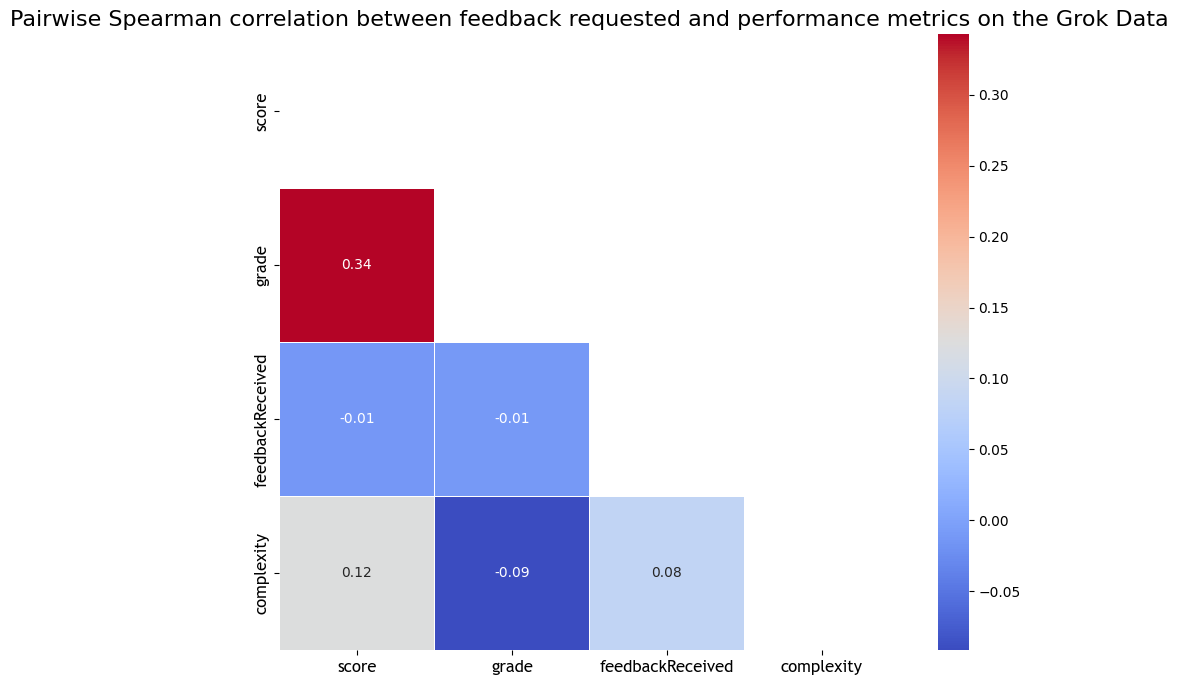

In [289]:
# # Create a mask for upper triangular portion
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a correlation heatmap with improved theme
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

# Set the title of the plot
plt.title('Pairwise Spearman correlation between feedback requested and performance metrics on the Grok Data', fontsize=16)

# # Customize the colorbar
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=12)

# Set the font size of the annotations
plt.xticks(fontsize=12, fontfamily="Trebuchet MS")
plt.yticks(fontsize=12, fontfamily="Trebuchet MS")

# Display the plot
plt.show()

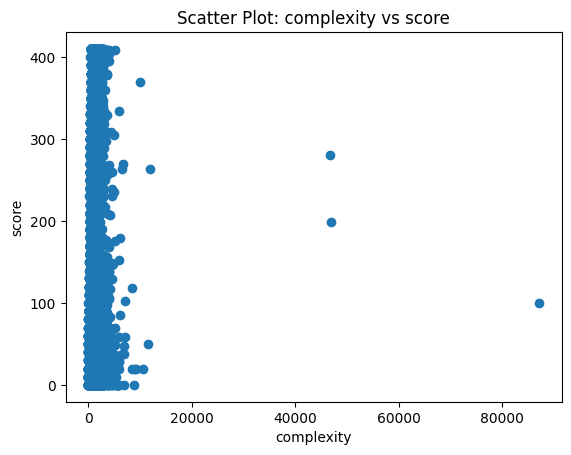

In [290]:
# RQ2
import matplotlib.pyplot as plt

x_name = 'complexity'
y_name = 'score'

# Assuming your DataFrame is named "df"
x = reduced[x_name]
y = reduced[y_name]

plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))
plt.show()

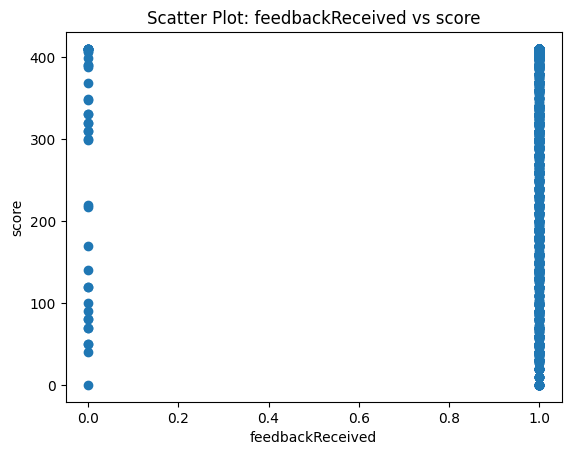

In [291]:
# RQ2
import matplotlib.pyplot as plt

x_name = 'feedbackReceived'
y_name = 'score'

# Assuming your DataFrame is named "df"
x = reduced[x_name]
y = reduced[y_name]

plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))
plt.show()

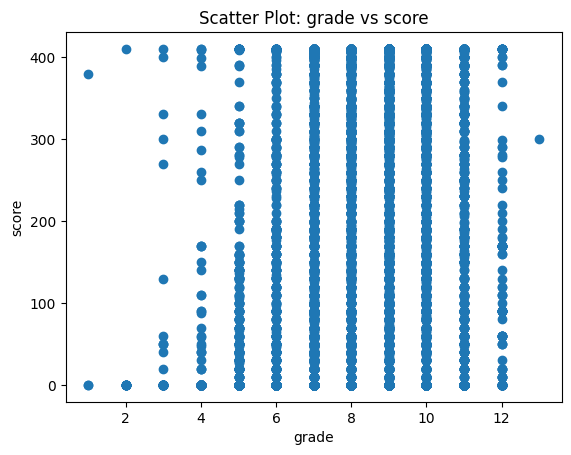

In [292]:
# RQ2
import matplotlib.pyplot as plt

x_name = 'grade'
y_name = 'score'

# Assuming your DataFrame is named "df"
x = reduced[x_name]
y = reduced[y_name]

plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))
plt.show()

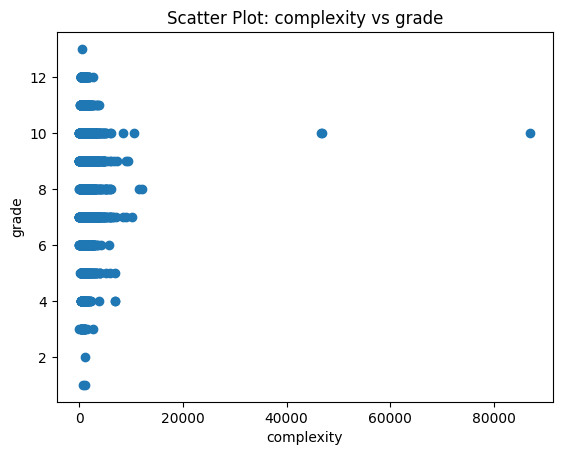

In [293]:
# RQ2
import matplotlib.pyplot as plt

x_name = 'complexity'
y_name = 'grade'

# Assuming your DataFrame is named "df"
x = reduced[x_name]
y = reduced[y_name]

plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))
plt.show()

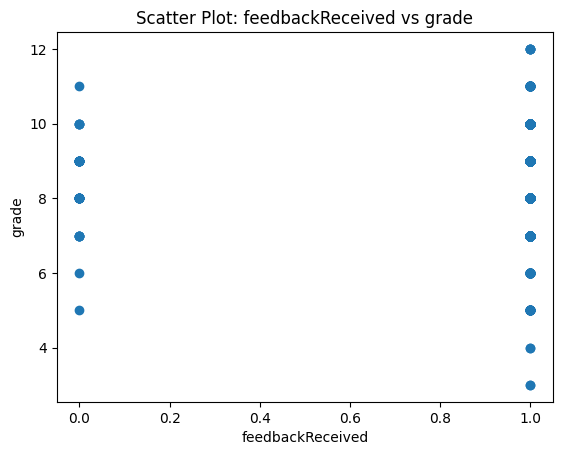

In [294]:
# RQ2
import matplotlib.pyplot as plt

x_name = 'feedbackReceived'
y_name = 'grade'

# Assuming your DataFrame is named "df"
x = reduced[x_name]
y = reduced[y_name]

plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))
plt.show()

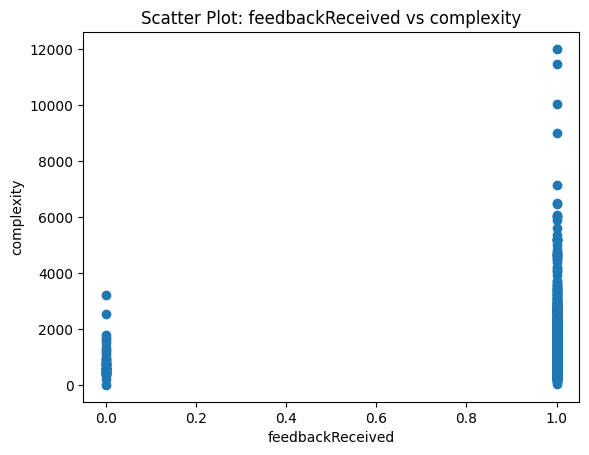

In [295]:
# RQ2
import matplotlib.pyplot as plt

x_name = 'feedbackReceived'
y_name = 'complexity'

# Assuming your DataFrame is named "df"
x = reduced[x_name]
y = reduced[y_name]

plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))
plt.show()